# Классификация изображений.

Классификация изображений. Семплирование изоборажений низкочастотных классов.








![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

In [ ]:

import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import datasets, transforms, models
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import tqdm
import time
from collections import Counter
import seaborn as sns

import shutil
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Данные можно скачать [ссылке](https://disk.yandex.ru/d/U9bpivZ-Tpknfw).

Скачиваем и распаковываем датасет.

- `!pip install wldhx.yadisk-direct`: Устанавливает библиотеку для работы с прямыми ссылками на Яндекс Диске. Это нужно, чтобы скачать файл без ручного ввода.
- `!curl -L $(yadisk-direct ...)`: Скачивает архив `journey-springfield.zip` и сохраняет его как `simpsons.zip`.
- `!unzip -qq simpsons.zip`: Распаковывает архив в текущую директорию. Флаг `-qq` делает это без лишнего вывода информации.

In [ ]:
!pip install wldhx.yadisk-direct
!curl -L $(yadisk-direct https://disk.yandex.ru/d/U9bpivZ-Tpknfw) -o simspons.zip
!unzip -qq simspons.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  520M  100  520M    0     0  16.0M      0  0:00:32  0:00:32 --:--:-- 20.3M


После распаковки данные организованы так:

- Папка `train/simpsons_dataset` содержит изображения для обучения, разделенные по подпапкам (имена персонажей).
- Папка `testset/testset` содержит тестовые изображения без меток.  
Определяем пути к данным и собираем списки файлов:

In [ ]:
train_dir = Path('train/simpsons_dataset')
test_dir = Path('testset/testset')

In [ ]:
train_val_files = list(train_dir.rglob('*.jpg'))
test_files = list(test_dir.rglob('*.jpg'))

In [ ]:
len(train_val_files)

20933

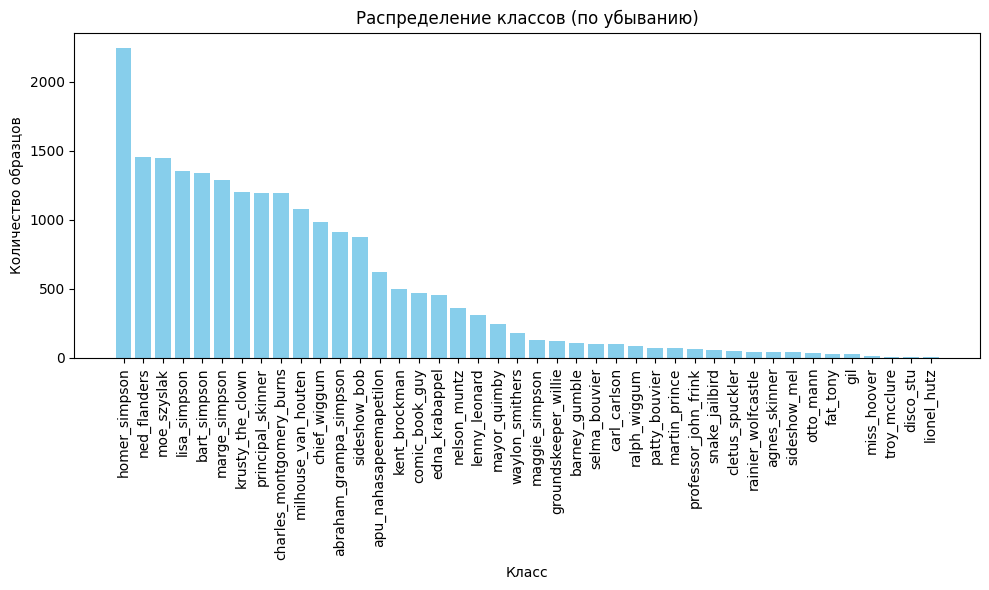

In [ ]:
train_val_labels = [path.parent.name for path in train_val_files]
# 1. Считаем количество экземпляров для каждого класса
class_counts = Counter(train_val_labels)

# 2. Сортируем по количеству в убывающем порядке
sorted_class_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

# Разделяем отсортированные значения на классы и их количества
classes, counts = zip(*sorted_class_counts)

# 3. Строим гистограмму
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Класс')
plt.ylabel('Количество образцов')
plt.title('Распределение классов (по убыванию)')
plt.xticks(rotation=90)  # Поворачиваем подписи оси X для удобства чтения
plt.tight_layout()
plt.show()

In [ ]:
df = pd.DataFrame(sorted_class_counts, columns=['Класс', 'Количество'])
df

,Класс,Количество
0,homer_simpson,2246
1,ned_flanders,1454
2,moe_szyslak,1452
3,lisa_simpson,1354
4,bart_simpson,1342
5,marge_simpson,1291
6,krusty_the_clown,1206
7,principal_skinner,1194
8,charles_montgomery_burns,1193
9,milhouse_van_houten,1079


In [ ]:
low_data_classes = [cls for cls, count in class_counts.items() if count < 100]
low_data_classes

['miss_hoover',
 'martin_prince',
 'fat_tony',
 'professor_john_frink',
 'rainier_wolfcastle',
 'otto_mann',
 'agnes_skinner',
 'snake_jailbird',
 'troy_mcclure',
 'patty_bouvier',
 'gil',
 'ralph_wiggum',
 'disco_stu',
 'cletus_spuckler',
 'carl_carlson',
 'lionel_hutz',
 'sideshow_mel']

In [ ]:
data_classes = [cls for cls, count in class_counts.items()]
data_classes

['ned_flanders',
 'nelson_muntz',
 'miss_hoover',
 'bart_simpson',
 'chief_wiggum',
 'principal_skinner',
 'krusty_the_clown',
 'martin_prince',
 'groundskeeper_willie',
 'mayor_quimby',
 'selma_bouvier',
 'sideshow_bob',
 'lisa_simpson',
 'milhouse_van_houten',
 'charles_montgomery_burns',
 'fat_tony',
 'barney_gumble',
 'professor_john_frink',
 'marge_simpson',
 'rainier_wolfcastle',
 'otto_mann',
 'agnes_skinner',
 'kent_brockman',
 'snake_jailbird',
 'maggie_simpson',
 'troy_mcclure',
 'patty_bouvier',
 'edna_krabappel',
 'gil',
 'ralph_wiggum',
 'abraham_grampa_simpson',
 'lenny_leonard',
 'disco_stu',
 'cletus_spuckler',
 'comic_book_guy',
 'carl_carlson',
 'homer_simpson',
 'apu_nahasapeemapetilon',
 'lionel_hutz',
 'moe_szyslak',
 'sideshow_mel',
 'waylon_smithers']

# Аугментация изображений

In [ ]:
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.33))
])

In [ ]:
def augment_and_save(image_path, output_folder, num_aug):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((224, 224))  # приводим к одному размеру
    tensor_image = transforms.ToTensor()(image)

    for i in range(num_aug):
        augmented = augmentation(tensor_image)
        aug_image = transforms.ToPILImage()(augmented)

        # Сохраняем новое изображение
        filename = f"{image_path.stem}_aug_{i}{image_path.suffix}"
        aug_image.save(output_folder / filename)

In [ ]:
def augment_class_images(class_name, train_dir, augment_and_save_func, num_aug=10):
    """
    Применяет аугментации к изображениям заданного класса и добавляет их обратно в датасет.

    :param class_name: имя папки с классом (например 'lionel_hutz')
    :param train_dir: путь к обучающей папке с датасетом
    :param augment_and_save_func: функция, которая применяет аугментации и сохраняет изображения
    :param num_aug: количество аугментированных версий на одно изображение
    """
    train_dir = Path(train_dir)
    output_dir = train_dir / f'{class_name}_augmented'
    output_dir.mkdir(exist_ok=True)

    # Находим все изображения нужного класса
    class_dir = train_dir / class_name
    if not class_dir.exists():
        raise ValueError(f"Папка {class_dir} не существует. Проверьте имя класса.")

    image_files = list(class_dir.glob('*.jpg'))

    if not image_files:
        print(f"Нет изображений в классе {class_name}")
        return

    # Применяем аугментацию к каждому файлу
    for file in image_files:
        augment_and_save_func(file, output_dir, num_aug)

    print(f"✅ Аугментированные изображения сохранены в: {output_dir}")

    # Копируем новые изображения обратно в оригинальную папку
    for src_file in output_dir.glob("*.jpg"):
        dest_file = class_dir / src_file.name
        if not dest_file.exists():
            shutil.copy(src_file, dest_file)
        else:
            print(f"Файл {src_file.name} уже существует. Пропуск.")

    # Удаляем временную папку
    if output_dir.exists():
        shutil.rmtree(output_dir)
        print(f"🗑️ Папка {output_dir} удалена.")
    else:
        print(f"❌ Папка {output_dir} не существует.")

In [ ]:
for cls in low_data_classes:
    augment_class_images(
        class_name=cls,
        train_dir='train/simpsons_dataset',
        augment_and_save_func=augment_and_save,
        num_aug=10
    )

✅ Аугментированные изображения сохранены в: train/simpsons_dataset/miss_hoover_augmented
🗑️ Папка train/simpsons_dataset/miss_hoover_augmented удалена.
✅ Аугментированные изображения сохранены в: train/simpsons_dataset/martin_prince_augmented
🗑️ Папка train/simpsons_dataset/martin_prince_augmented удалена.
✅ Аугментированные изображения сохранены в: train/simpsons_dataset/fat_tony_augmented
🗑️ Папка train/simpsons_dataset/fat_tony_augmented удалена.
✅ Аугментированные изображения сохранены в: train/simpsons_dataset/professor_john_frink_augmented
🗑️ Папка train/simpsons_dataset/professor_john_frink_augmented удалена.
✅ Аугментированные изображения сохранены в: train/simpsons_dataset/rainier_wolfcastle_augmented
🗑️ Папка train/simpsons_dataset/rainier_wolfcastle_augmented удалена.
✅ Аугментированные изображения сохранены в: train/simpsons_dataset/otto_mann_augmented
🗑️ Папка train/simpsons_dataset/otto_mann_augmented удалена.
✅ Аугментированные изображения сохранены в: train/simpsons_dat

In [ ]:
train_val_files = list(train_dir.rglob('*.jpg'))
len(train_val_files)


28393

`Path` и спользуется из модуля `pathlib` для удобной работы с путями к файлам. Это делает код кроссплатформенным.
`rglob('*.jpg')` рекурсивно находит все файлы с расширением `.jpg` в указанных директориях.

Для обучения и оценки модели нужно разделить данные на обучающую и валидационную выборки:

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

Извлекаем метки классов (имена персонажей) из названий родительских папок.
А train_test_split делит данные на две части:
- train_files (75%) — для обучения.
- val_files (25%) — для валидации.
- `stratify=train_val_labels` гарантирует, что пропорции классов сохраняются в обеих выборках (важно, если классы несбалансированы).

Даталоадер за вас уже написаны :)

Для работы с данными используется класс `SimpsonsDataset`. Он наследуется от `torch.utils.data.Dataset` и отвечает за загрузку, обработку и преобразование изображений.

Принимает список файлов и режим (train, val, test):
- В режимах train и val создается LabelEncoder для преобразования имен классов в числовые идентификаторы.
- В режиме test метки не нужны, так как их нет в тестовых данных.
- Метод `__getitem__` pагружает изображение (load_sample), приводит его к размеру 224x224 (`_prepare_sample`), преобразует в тензор и нормализует с помощью `transforms.Compose` и возвращает тензор изображения и (для train/val) метку класса.

In [ ]:
# разные режимы загрузки датасета
data_modes = ['train', 'val', 'test']

class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит масштабирование и преобразование в тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        self.len_ = len(self.files)

        # Создаем энкодер для преобразования текстовых меток в числовые
        self.label_encoder = LabelEncoder()

        # Для режимов train и val получаем метки из имен директорий
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)


    def __len__(self):
        return self.len_

    def load_sample(self, file):
        """Загрузка изображения из файла"""
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        """
        Получение одного элемента датасета по индексу.
        Для режима test возвращает только изображение,
        для train и val возвращает пару (изображение, метка)
        """
        # Определяем преобразования для нормализации изображений
        # Параметры нормализации основаны на статистике ImageNet
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
       # Загружаем и подготавливаем изображение
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)

        # Для тестового режима возвращаем только изображение
        if self.mode == 'test':
            return x
        else:
            # Для train и val режимов дополнительно возвращаем метку класса
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        """Приведение изображения к единому размеру 224x224"""
        image = image.resize((224, 224))
        return np.array(image)

In [ ]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

Теперь определим функции для отображения картинок и выведем 9 случайных из трейна.

Функция преобразует тензор обратно в изображение, `transpose((1, 2, 0))` меняет порядок осей с (C, H, W) на (H, W, C) и делает обратную нормализацию: добавляет среднее и умножает на стандартное отклонение.

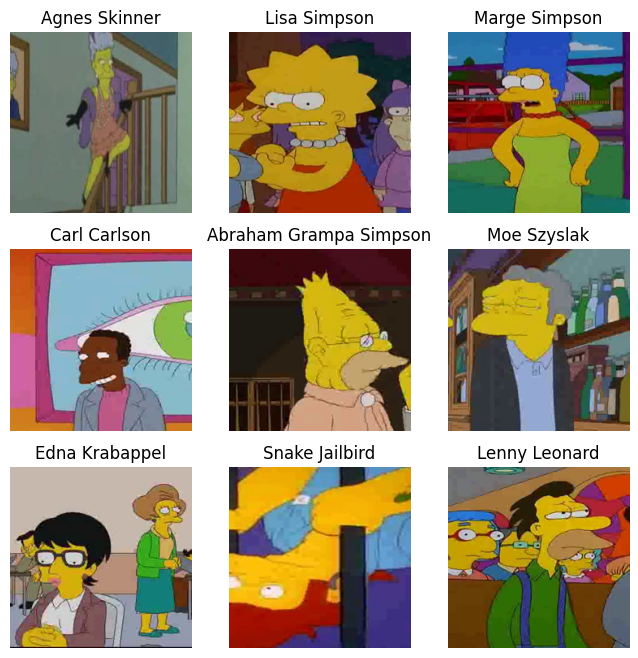

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """
    Функция для отображения тензоров как изображений.
    Производит обратную нормализацию для правильного отображения.
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)  # Добавим ограничение значений
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.axis('off')  # Отключаем оси

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, len(train_dataset)))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)
plt.show()

Используйте все полученные знания (можно и выйти за рамки пройденного материала), чтобы добиться наилучшего качества модели на валидационном наборе данных (accuracy).
Минимальное требуемое значения метрики - 0.83. Постарайтесь получить 0.95+ ;)  
На тесте сделайте визуальную проверку результатов.

Кроме построения нейросети и оценки её качества вам необходимо:
- замерять время обучения сети;
- написать функцию, которая на вход будет принимать ссылку на произвольное изображение и прогнозировать его класс;
- написать код, который будет выводть случайные изображения из теста с прогнозами для демонстрации того, где модель ошибается.

Изучите классы, на которых модель чаще всего ошибается, напишите финальные выводы и пути дальнейшего улучшения работы.

**Рекомендуемый план работы**

Изучение данны:
1. Изучите распределение классов.
2. Проверьте качество изображений.
3. Определите потенциально сложные классы классификации моделью.

Базовое решение:
1.   Обучить простую модель, используя предобученную архитектуру. При желании попробуйте реализовать свою архитектуру с нуля, это не обязательно, но будет плюсом.
2.   Оцените метрики на валидации и время обучения, постройте матрицу ошибок.
3. Выведите прогнозы для набора изображений из тестовой выборки, проанализируйте, на каких изображениях модель ошибается чаще всего. Выдвините гипотезы о причинах.
4. Напишите функцию, принимающую URL изображения, производящую все необходимые преобразования (загрузка, изменение размера, нормализация) и возвращающую предсказанный класс.

Оптимизация:
1. Добавьте аугментацию данных, чтобы повысить устойчивость модели, уменьшить переобучение, улучшить баланс классов.
2. Экспериментируйте с гиперпараметрами используемых моделей (learning rate, batch size, количество эпох, оптимизатор).
3. Экспериментируйте с transfer learning. Попробуйте разные предобученные модели, замораживая разное количество слоев.

Предложите возможные направления для улучшения.


Чтобы не огранчиваться мощностями Colab, можете попробовать [задействовать мощности](https://www.kaggle.com/docs/notebooks#kaggle-jupyter-server) Kaggle. Они дают CPU без лимита, 30ч GPU / 20ч TPU в неделю + 330 ГБ RAM).

Работает просто:
1️⃣ Открываете ноутбук на Kaggle → жмёте Run > Kaggle Jupyter Server.
2️⃣ Выбираете редактор: Colab или VS Code (через специальный URL).

In [ ]:
n_classes = np.unique(train_val_labels)
n_classes

array(['abraham_grampa_simpson', 'agnes_skinner',
       'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson',
       'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum',
       'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel',
       'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson',
       'kent_brockman', 'krusty_the_clown', 'lenny_leonard',
       'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson',
       'martin_prince', 'mayor_quimby', 'milhouse_van_houten',
       'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz',
       'otto_mann', 'patty_bouvier', 'principal_skinner',
       'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum',
       'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird',
       'troy_mcclure', 'waylon_smithers'], dtype='<U24')

In [ ]:
print(f"Обучающая выборка состоит из {len(train_files)} изображенийй")
print(f"Валидационная выборка состоит из {len(val_files)} изображений")
print(f"Тестовая выборка состоит из {len(test_files)} изображений")

Обучающая выборка состоит из 21294 изображенийй
Валидационная выборка состоит из 7099 изображений
Тестовая выборка состоит из 991 изображений


In [ ]:
def train(model, train_loader, val_loader, loss_fn, optimizer, epochs):
    model.to(device)

    model.train()

    start_time = time.time()  # Запоминаем начало обучения

    for epoch in range(epochs):
        # итерируем по батчам на трейне
        for X_batch, y_batch in train_loader:
            # переводим батчи на GPU
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # получаем предсказания модели для батча
            y_pred = model(X_batch)
            # вычисляем функцию потерь для батча
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # вызываем функцию evaluate на валидации и получаем значения функции потерь и точности
        print(f'Эпоха {epoch+1}')
        val_loss, val_accuracy = evaluate(model, val_loader, loss_fn)

    end_time = time.time()  # Запоминаем конец обучения
    total_time = end_time - start_time
    print(f"\nОбщее время обучения: {total_time:.2f} секунд")

    return model, total_time

def evaluate(model, data_loader, loss_fn):
    total_loss = 0
    correct = 0
    model.to(device)
    # переводим модель в режим оценки
    model.eval()
    # включаем контекстный менеджер для инференса
    with torch.inference_mode():
        # итерируем по батчам
        for X, y in data_loader:
            # переводим батчи на GPU
            X, y = X.to(device), y.to(device)
            # делаем предсказания модели
            pred = model(X)
            # вычисляем функцию потерь
            loss = loss_fn(pred, y)
            # добавляем функцию потерь к суммарной
            total_loss += loss.item()
            # получаем индексы максимальных значений в предсказаниях модели
            pred = torch.argmax(pred, dim=1)
            # сравниваем предсказания модели с метками и считаем, сколько раз они совпадают
            correct += torch.sum(pred == y).item()

    # вычисляем среднюю функцию потерь по данным
    mean_loss = total_loss / len(data_loader)
    # вычисляем точность по данным
    accuracy = correct / len(data_loader.dataset)

    print(f"Функция потерь (кросс-энтропия) на данных {mean_loss}")
    print(f"Точность на данных {accuracy}")

    return mean_loss, accuracy

In [ ]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=128)
loss_fn = torch.nn.CrossEntropyLoss()

# Resnet50

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
model.fc = nn.Linear(2048, 42)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

trained_model, trained_time = train(model, train_loader, val_loader, loss_fn, optimizer, epochs=10)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 0.23515419206482224
Точность на данных 0.9335201793721973
Эпоха 2
Функция потерь (кросс-энтропия) на данных 3.3900119611195154
Точность на данных 0.12567264573991033
Эпоха 3
Функция потерь (кросс-энтропия) на данных 3.275439396926335
Точность на данных 0.15762331838565022
Эпоха 4
Функция потерь (кросс-энтропия) на данных 2.6946591237826008
Точность на данных 0.21614349775784752
Эпоха 5
Функция потерь (кросс-энтропия) на данных 2.254141907606806
Точность на данных 0.35134529147982063
Эпоха 6
Функция потерь (кросс-энтропия) на данных 1.5122257445539746
Точность на данных 0.5734304932735426
Эпоха 7
Функция потерь (кросс-энтропия) на данных 1.0795249230627502
Точность на данных 0.6889013452914798
Эпоха 8
Функция потерь (кросс-энтропия) на данных 0.7328432788274117
Точность на данных 0.7915919282511211
Эпоха 9
Функция потерь (кросс-энтропия) на данных 0.5510296278317193
Точность на данных 0.8458520179372198
Эпоха 10
Функция потерь (кросс-энт

In [ ]:
trained_model_mean_loss, trained_model_accuracy = evaluate(trained_model, val_loader, loss_fn)

In [ ]:
#Датафрейм для хранения результатов
mod = pd.DataFrame(columns=["Модель сети", "Accuracy на валидации", 'Время обучения'])

# Добавляем строку с результатами
mod.loc[len(mod)] = ["0_resnet50(weights=pretrained)", trained_model_accuracy, trained_time]

In [ ]:
mod

In [ ]:
# Сохраняем модель
# --- Создаем директорию для моделей (если ее нет) ---
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # Создать родительские директории, если нужно
                 exist_ok=True) # Не вызывать ошибку, если директория уже существует

# --- Определяем имя файла для сохранения ---
MODEL_NAME = "0_pytorch_resnet50_wieghts.pth" # Используем расширение .pth или .pt
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"\nСохраняем state_dict модели в: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # Сохраняем  state_dict
           f=MODEL_SAVE_PATH)
print("Модель сохранена.")

# resnet18

In [ ]:
model_1 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


In [ ]:
def create_model(model, num_freeze_layers, num_out_classes):
    # замена последнего слоя сети
    model.fc = nn.Linear(512, num_out_classes)

    # заморозка слоев
    for i, layer in enumerate(model.children()):
        if i <= num_freeze_layers:
            for param in layer.parameters():
                param.requires_grad = False

    return model

In [ ]:
model_1 = create_model(models.resnet18(weights=models.ResNet18_Weights.DEFAULT), 8, 42)
model_1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=1e-3)
trained_model_1, trained_time_1 = train(model_1, train_loader, val_loader, loss_fn, optimizer_1, epochs=10)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 1.4050092459789345
Точность на данных 0.6928251121076233
Эпоха 2
Функция потерь (кросс-энтропия) на данных 1.0385974333754608
Точность на данных 0.7619955156950673
Эпоха 3
Функция потерь (кросс-энтропия) на данных 0.8926418006420136
Точность на данных 0.7883408071748879
Эпоха 4
Функция потерь (кросс-энтропия) на данных 0.8313141704137836
Точность на данных 0.7955156950672646
Эпоха 5
Функция потерь (кросс-энтропия) на данных 0.7683989561029843
Точность на данных 0.8047085201793722
Эпоха 6
Функция потерь (кросс-энтропия) на данных 0.72294876234872
Точность на данных 0.8162556053811659
Эпоха 7
Функция потерь (кросс-энтропия) на данных 0.69870959892869
Точность на данных 0.8183856502242153
Эпоха 8
Функция потерь (кросс-энтропия) на данных 0.6923329598137311
Точность на данных 0.8197309417040358
Эпоха 9
Функция потерь (кросс-энтропия) на данных 0.6663472002638238
Точность на данных 0.8255605381165919
Эпоха 10
Функция потерь (кросс-энтропия) 

In [ ]:
trained_model_mean_loss_1, trained_model_accuracy_1 = evaluate(trained_model_1, val_loader, loss_fn)

Функция потерь (кросс-энтропия) на данных 0.6487829933475171
Точность на данных 0.83195067264574


In [ ]:
# Добавляем строку с результатами
mod.loc[len(mod)] = ["1_resnet18(Weights.DEFAULT), frozen8", trained_model_accuracy_1, trained_time_1]
mod

,Модель сети,Accuracy на валидации,Время обучения
0,0_resnet50(weights=pretrained),0.113489,901.450039
1,"1_resnet18(Weights.DEFAULT), frozen8",0.763661,1139.846214


In [ ]:
# --- Определяем имя файла для сохранения ---
MODEL_NAME = "1_pytorch_resnet18_wieghts_frozen8.pth" # Используем расширение .pth или .pt
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"\nСохраняем state_dict модели в: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # Сохраняем  state_dict
           f=MODEL_SAVE_PATH)
print("Модель сохранена.")


Сохраняем state_dict модели в: models/1_pytorch_resnet18_wieghts_frozen8.pth
Модель сохранена.


# resnet18(заморозка 5 слоев)

In [ ]:
model_2 = create_model(models.resnet18(weights=models.ResNet18_Weights.DEFAULT), 5, 42)
model_2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=1e-3)
trained_model_2, trained_time_2 = train(model_2, train_loader, val_loader, loss_fn, optimizer_2, epochs=10)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 0.22261817161259906
Точность на данных 0.9435131708691366
Эпоха 2
Функция потерь (кросс-энтропия) на данных 3.50206515618733
Точность на данных 0.058458937878574445
Эпоха 3
Функция потерь (кросс-энтропия) на данных 3.0871569556849345
Точность на данных 0.1246654458374419
Эпоха 4
Функция потерь (кросс-энтропия) на данных 2.894434560622488
Точность на данных 0.17551767854627412
Эпоха 5
Функция потерь (кросс-энтропия) на данных 2.1525584597672736
Точность на данных 0.3907592618678687
Эпоха 6
Функция потерь (кросс-энтропия) на данных 1.2794609091111593
Точность на данных 0.6433300464854205
Эпоха 7
Функция потерь (кросс-энтропия) на данных 0.9465393543775592
Точность на данных 0.7350331032539794
Эпоха 8
Функция потерь (кросс-энтропия) на данных 0.7269932352937758
Точность на данных 0.8049020988871672
Эпоха 9
Функция потерь (кросс-энтропия) на данных 0.6725718587799098
Точность на данных 0.8294125933230032
Эпоха 10
Функция потерь (кросс-энтро

In [ ]:
trained_model_mean_loss_2, trained_model_accuracy_2 = evaluate(trained_model_2, val_loader, loss_fn)

Функция потерь (кросс-энтропия) на данных 0.4240741892551471
Точность на данных 0.8860402873644175


In [ ]:
#Датафрейм для хранения результатов
mod = pd.DataFrame(columns=["Модель сети", "Accuracy на валидации", 'Время обучения'])

# Добавляем строку с результатами
mod.loc[len(mod)] = ["0_resnet18(weights=pretrained)+frozen5", trained_model_accuracy_2, trained_time_2]

In [ ]:
mod

,Модель сети,Accuracy на валидации,Время обучения
0,0_resnet18(weights=pretrained)+frozen5,0.88604,1377.19065


# alexnet

In [ ]:
model_3 = models.alexnet(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#другой способ реализации, отличающийся от применения в resnet18
from itertools import chain

layers_to_unfreeze = 5

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_3.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 4096
# Заменяем Fully-Connected слой на наш линейный классификатор
model_3.classifier[6] = nn.Linear(num_features, 42)

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой
# parameters() возвращает просто список тензоров парамтеров, поэтому два таких списка можно сложить
optimizer_3 = torch.optim.Adam(
    chain(
        list(model_3.features.parameters())[-layers_to_unfreeze:],
        model_3.classifier.parameters()
    ),
    lr=1e-3,
)

In [ ]:
trained_model_3, trained_time_3 = train(model_3, train_loader, val_loader, loss_fn, optimizer_3, epochs=10)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 0.5307470882045371
Точность на данных 0.8644879560501479
Эпоха 2
Функция потерь (кросс-энтропия) на данных 0.4082191150768527
Точность на данных 0.8984363994928863
Эпоха 3
Функция потерь (кросс-энтропия) на данных 0.5551941404285442
Точность на данных 0.8778701225524722
Эпоха 4
Функция потерь (кросс-энтропия) на данных 0.5148225109525291
Точность на данных 0.8932243978025074
Эпоха 5
Функция потерь (кросс-энтропия) на данных 0.5535527119146926
Точность на данных 0.9023806169883082
Эпоха 6
Функция потерь (кросс-энтропия) на данных 0.5280548911874315
Точность на данных 0.9059022397520777
Эпоха 7
Функция потерь (кросс-энтропия) на данных 0.6032502300139575
Точность на данных 0.8975912100295816
Эпоха 8
Функция потерь (кросс-энтропия) на данных 0.5746093113973204
Точность на данных 0.9108325116213551
Эпоха 9
Функция потерь (кросс-энтропия) на данных 0.6523723004918013
Точность на данных 0.9074517537681364
Эпоха 10
Функция потерь (кросс-энтроп

In [ ]:
trained_model_mean_loss_3, trained_model_accuracy_3 = evaluate(trained_model_3, val_loader, loss_fn)

Функция потерь (кросс-энтропия) на данных 0.6856742139373507
Точность на данных 0.9064656993942809


In [ ]:
mod.loc[len(mod)] = ["3_alexnet(pretrained=True)+unfreeze5", trained_model_accuracy_3, trained_time_3]
mod

,Модель сети,Accuracy на валидации,Время обучения
0,0_resnet18(weights=pretrained)+frozen5,0.886040,1377.190650
1,3_alexnet(pretrained=True)+unfreeze5,0.906466,1268.944335


In [ ]:
MODEL_PATH = Path("models")
# --- Определяем имя файла для сохранения ---
MODEL_NAME = "3_pytorch_alexnet_unfreeze5.pth" # Используем расширение .pth или .pt
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"\nСохраняем state_dict модели в: {MODEL_SAVE_PATH}")
torch.save(obj=model_3.state_dict(), # Сохраняем  state_dict
           f=MODEL_SAVE_PATH)
print("Модель сохранена.")


Сохраняем state_dict модели в: models/3_pytorch_alexnet_unfreeze5.pth


RuntimeError: Parent directory models does not exist.

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
from torchmetrics import ConfusionMatrix

In [ ]:
def get_all_preds(model, loader):
    model.eval()
    with torch.inference_mode():
        preds = []
        labels = []
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            preds.append(pred.cpu())
            labels.append(y.cpu())
        preds = torch.cat(preds, dim=0)
        labels = torch.cat(labels, dim=0)
        pred_classes = preds.argmax(dim=1)
        return labels, pred_classes

In [ ]:
def showmatrix(conf):
    df_conf = pd.DataFrame(conf,
                       index=[f"y_true={i}" for i in data_classes],
                       columns=[f"y_pred={i}" for i in data_classes])
    plt.figure(figsize=(16, 14))
    sns.heatmap(df_conf, annot=True, cmap='Blues', fmt='g')

In [ ]:
test_labels, test_preds = get_all_preds(trained_model_3, val_loader)

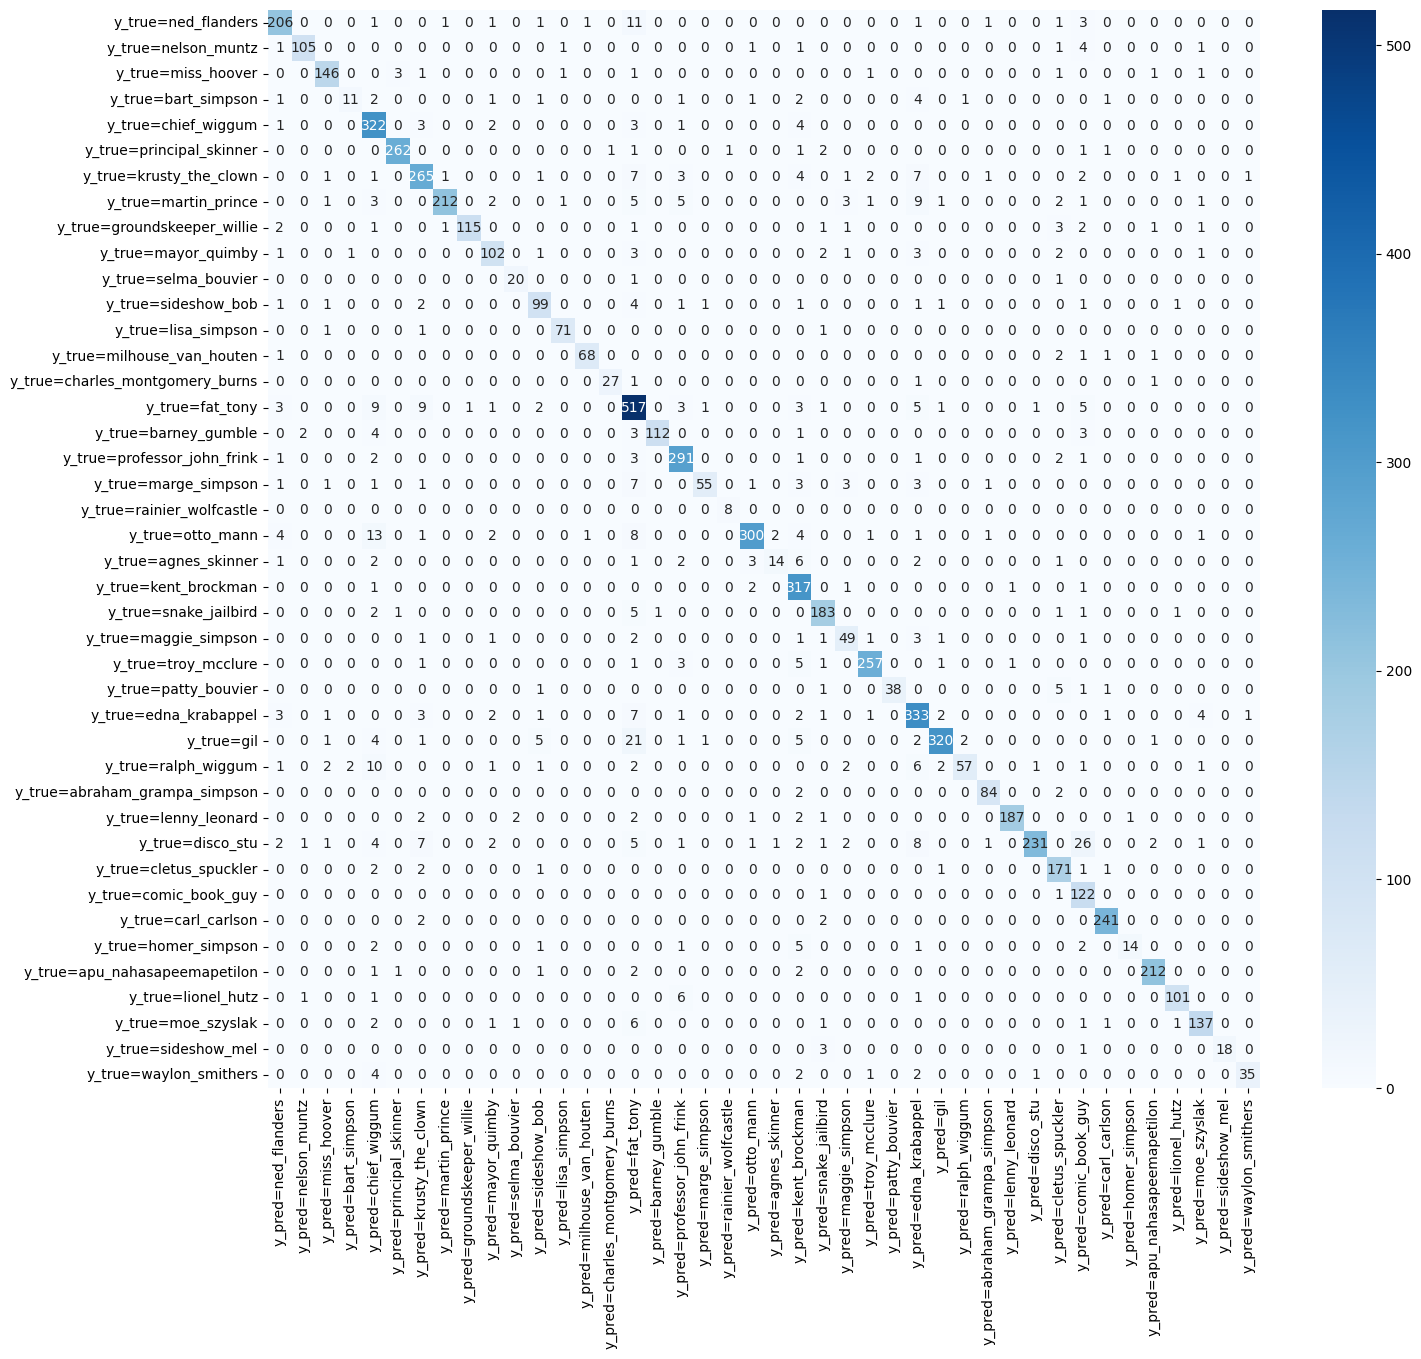

In [ ]:
confmat = ConfusionMatrix(task='multiclass', num_classes=42)
confusion_matrix = confmat(test_preds, test_labels)
showmatrix(confusion_matrix)

1. resnet50+аугментация - 0.8799 - 2919 сек
2. resnet50+безаугментации+без весов - 0.1134 - 901 сек
3. resnet18+заморозка 8 слоев+аугментация - 0.8319 - 1548 сек
4. resnet18+заморозка 5 слоев+аугментация - 0.8860 - 1377 сек
5. resnet18+заморозка 8 слоев+безаугментации - 0.7636 - 1139 сек
6. alexnet+заморозка всех весов +безаугментации -  0.7678 - 1128 сек
7.alexnet+разморозка 5 последних слоев +аугментация -  0.9064 - 1269 сек


# Проверка

In [ ]:
import requests
from io import BytesIO
from PIL import Image

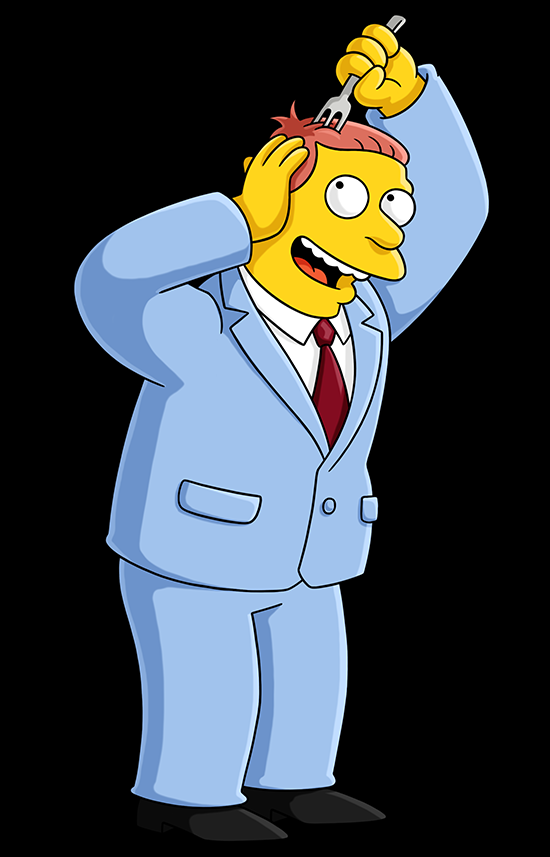

In [ ]:
url = 'https://static.wikia.nocookie.net/simpsons/images/e/ed/Lionel_Hutz.png/revision/latest?cb=20171127153913'
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert('RGB')
image

In [ ]:
pretrained_transforms = models.AlexNet_Weights.DEFAULT.transforms()

In [ ]:
transformed_img = pretrained_transforms(image)
# Добавляем batch dimension (модели ожидают вход [batch_size, channels, H, W])
input_tensor = transformed_img.unsqueeze(0)

In [ ]:
# Перемещаем тензор на GPU, если модель там
device = next(model_3.parameters()).device
input_tensor = input_tensor.to(device)

In [ ]:
# Шаг 3: Предсказание модели
model_3.eval()
with torch.no_grad():
    output = model_3(input_tensor)

# Шаг 4: Получаем индекс класса с максимальной вероятностью
predicted_class = output.argmax(dim=1).item()

predicted_class_name = data_classes[predicted_class]
print(f"Предсказанный класс: {predicted_class_name} (номер {predicted_class})")

Предсказанный класс: waylon_smithers (номер 41)
